<img src='../../media/common/LogoWekeo_Copernicus_RGB_0.png' align='left' height='96px'></img>

<hr>

# Grassland Classification

*Authors: Adrian Di Paolo, Chung-Xiang Hong, Jonas Viehweger* 

This notebook will demonstrate how to clean up and pre process satellite data for a machine learning task. It will also go into detail on how to use the cleaned data to train, evaluate and select a model for a larger scale application. 

The task is to train a model which can classify grassland areas in the Netherlands. The ultimate goal would be to classify grasslands yearly to derive change maps of grassland loss and gain from them. To do the classification we are using phenological data and the EuroCrops Dataset as ground truth.

This notebook uses data that was already downloaded and prepared for Python in the previous notebook.

1. [Preprocessing Data](#preprocessing-data)

    - [Labeling Data](#labeling-the-data)

    - [Data Cleaning](#data-cleaning)

    - [Normalizing Dates](#normalizing-dates)

    - [Normalizing Numerical Data](#normalize-numerical-data)

    - [Split Dataset into Train and Test](#split-the-dataset-into-train-and-test) 

2. [Model Training](#model-training)

    
3. [Model Evaluation](#model-evaluation)

    - [Metrics](#metrics)

    - [Memory Usage](#memory-usage)

    - [Execution Time](#execution-time) 

    - [Confusion Matrix](#confusion-matrtix)

    - [ROC Curve](#roc-curve)
    
4. [Model Selection](#model-selection)

    - [Fine-tuning](#hyperparameter-optimization)

    - [Feature Importance](#feature-importance)

5. [Neural Network](#bonus-training-neural-network)



In [161]:
library(dplyr)
library(lubridate)
library(caret)
library(naivebayes)
library(lightgbm)
library(doParallel)

library(ggplot2)
library(gridExtra)
library(pROC)

library(MLmetrics)
library(keras)

### Preprocessing Data


In [1]:
# Load the downloaded data
x_data <- readRDS('../../data/processing/ml-grassland-classification/dataset/x_data.rds')
y_data <- readRDS('../../data/processing/ml-grassland-classification/dataset/y_data.rds')

x_data <- x_data
y_data <- y_data

#### Labeling the data

We assign a 1 to the grassland label and 0 for others. 

In [122]:
binary_label <- function(y_data) {
    # Assign new labels: 1 if grassland, else 0
    grassland_value_str <- format(3.302e+09, scientific = TRUE)

    # Convert the array to strings in scientific notation
    y_data_str <- sapply(y_data, format, scientific = TRUE)

    binary_assign <- function(x) {
        ifelse(x == grassland_value_str, 1, 0)
    }

    sapply(y_data_str, binary_assign, USE.NAMES = FALSE)
}

#### Normalizing Dates

In [123]:
y_data <- binary_label(y_data)

##### Split Dataset into Train and Test

In [124]:
set.seed(42)
trainIndex <- createDataPartition(y_data, p = .8, list = FALSE, times = 1)

x_data_m <- as.matrix(x_data)

X_train <- x_data_m[trainIndex, ]
X_test <- x_data_m[-trainIndex, ]
y_train <- y_data[trainIndex]
y_test <- y_data[-trainIndex]

#### Undersampling Dataset

Undersampling is a technique used to balance imbalanced datasets, where one class has significantly more samples than another class.

The main advantage of undersampling is that it can improve the performance of classifiers by reducing the bias towards the majority class, which can lead to better predictions on the minority class. Undersampling can also reduce the training time and memory requirements of the model, since there are fewer instances to process.

In [126]:
# Compute class distribution before undersampling
class_counts_before <- table(y_train)
print(class_counts_before)

y_train
    0     1 
87120 32880 


In [127]:
# Combine X_train and y_train into a single data frame
train_data <- data.frame(X_train)
train_data$y_train <- as.factor(y_train)

# Perform undersampling using the `downSample` function
undersampled_data <- downSample(x = train_data[, -ncol(train_data)], y = train_data$y_train)

# # Split back into X_train and y_train
X_train_undersampled <- undersampled_data[, -ncol(undersampled_data)]
y_train_undersampled <- undersampled_data$Class

         Class Count Percent
1 No Grassland 87120    72.6
2    Grassland 32880    27.4


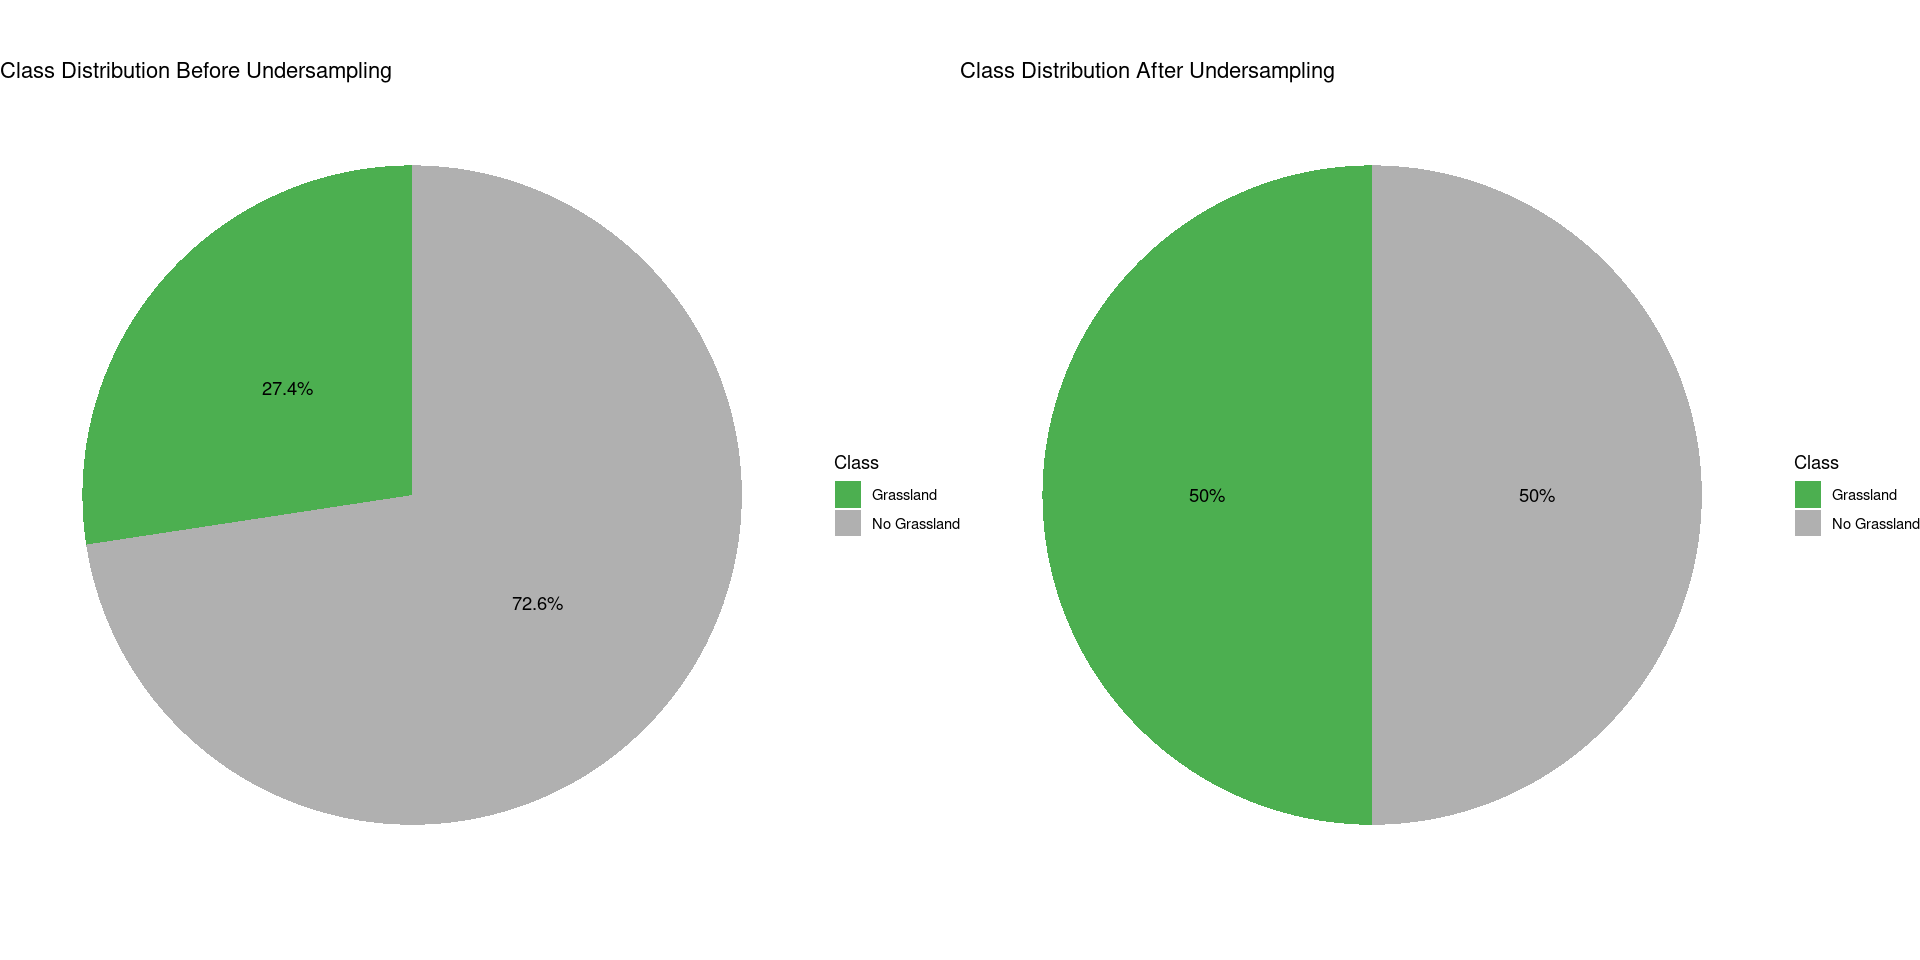

In [128]:
class_counts_after <- table(y_train_undersampled)

# Convert to data frames for ggplot
class_counts_before_df <- as.data.frame(class_counts_before)
colnames(class_counts_before_df) <- c("Class", "Count")
class_counts_before_df$Class <- factor(class_counts_before_df$Class, levels = c("1", "0"), labels = c("Grassland", "No Grassland"))
class_counts_before_df$Percent <- round(class_counts_before_df$Count / sum(class_counts_before_df$Count) * 100, 1)


class_counts_after_df <- as.data.frame(class_counts_after)
colnames(class_counts_after_df) <- c("Class", "Count")
class_counts_after_df$Class <- factor(class_counts_after_df$Class, levels = c("1", "0"), labels = c("Grassland", "No Grassland"))
class_counts_after_df$Percent <- round(class_counts_after_df$Count / sum(class_counts_after_df$Count) * 100, 1)


# Create pie chart for class distribution before undersampling
plot_before <- ggplot(class_counts_before_df, aes(x = "", y = Count, fill = Class)) +
  geom_bar(stat = "identity", width = 1) +
  coord_polar(theta = "y") +
  scale_fill_manual(values = c("Grassland" = "#4CAF50", "No Grassland" = "#B0B0B0")) +
  theme_void() +
  theme(legend.position = "right") +
  geom_text(aes(label = paste0(Percent, "%")), position = position_stack(vjust = 0.5)) +
  ggtitle("Class Distribution Before Undersampling")

# Create pie chart for class distribution after undersampling
plot_after <- ggplot(class_counts_after_df, aes(x = "", y = Count, fill = Class)) +
  geom_bar(stat = "identity", width = 1) +
  coord_polar(theta = "y") +
  scale_fill_manual(values = c("Grassland" = "#4CAF50", "No Grassland" = "#B0B0B0")) +
  theme_void() +
  theme(legend.position = "right") +
  geom_text(aes(label = paste0(Percent, "%")), position = position_stack(vjust = 0.5)) +
  ggtitle("Class Distribution After Undersampling")

options(repr.plot.width = 16, repr.plot.height = 8)
# # Arrange the plots side by side
grid.arrange(plot_before, plot_after, ncol = 2)

### Model Training

Here we are testing quite a few different algorithms on their performance for the task. 
It has to be noted that this is a quite naive and brute force approach to the task, since the models hyperparameters aren't tweaked and no pre-selection of machine learning algorithms based on expert knowledge is made. 

However it will give a rough idea on the performance of the algorithms and in addition it will provide information on the computational efficiency of the algorithms in terms of memory usage and computation time. These are also important parameters to consider when scaling the model up.

In [ ]:
# Prepare data
X_train <- matrix(X_train_undersampled, ncol = 1)
X_train[is.na(X_train)] <- -1

y_train <- y_train_undersampled

# Shuffling the data is crucial for gradient boosting models like LightGBM. It ensures that the training
# and validation sets are representative of the overall dataset, which helps the model learn generalizable
# patterns. This prevents biases and overfitting to the order of the data, improving the robustness and
# performance of the gradient boosting process.

set.seed(123) # For reproducibility

data <- data.frame(X = X_train, y = y_train)
shuffled_data <- data[sample(nrow(data)), ]

X_train <- as.matrix(shuffled_data$X)
y_train <- as.vector(shuffled_data$y)


models <- {}

# Metrics initialization
accuracy <- list()
precision <- list()
recall <- list()
f1 <- list()
time_usage <- list()

train_data <- data.frame(X_train = X_train, y_train = y_train)

# Logistic Regression
start_time <- Sys.time()
models[["Logistic Regression"]] <- train(y_train ~ .,
  data = train_data,
  method = "glm",
  family = binomial,
  trControl = trainControl(method = "cv", number = 10, allowParallel = TRUE),
  maxit = 1000
)
time_usage[["Logistic Regression"]] <- as.numeric(difftime(Sys.time(), start_time, units = "secs"))

# Support Vector Machines
start_time <- Sys.time()
models[["Support Vector Machines"]] <- train(y_train ~ .,
  data = train_data,
  method = "svmLinear",
  trControl = trainControl(method = "cv", number = 10, allowParallel = TRUE)
)
time_usage[["Support Vector Machines"]] <- as.numeric(difftime(Sys.time(), start_time, units = "secs"))

# Decision Trees
start_time <- Sys.time()
models[["Decision Trees"]] <- train(y_train ~ .,
  data = train_data,
  method = "rpart",
  trControl = trainControl(method = "cv", number = 10, allowParallel = TRUE),
  tuneLength = 10
)
time_usage[["Decision Trees"]] <- as.numeric(difftime(Sys.time(), start_time, units = "secs"))


# Naive Bayes
start_time <- Sys.time()
models[["Naive Bayes"]] <- train(y_train ~ .,
  data = train_data,
  method = "naive_bayes",
  trControl = trainControl(method = "cv", number = 10, allowParallel = TRUE),
  tuneLength = 10
)
time_usage[["Naive Bayes"]] <- as.numeric(difftime(Sys.time(), start_time, units = "secs"))

# K-Nearest Neighbors
# start_time <- Sys.time()
# models[["K-Nearest Neighbor"]] <- train(y_train ~ .,
#   data = train_data,
#   method = "knn",
#   trControl = trainControl(method = "cv", number = 10, allowParallel = TRUE),
#   tuneGrid = expand.grid(k = c(seq(5, 15, by = 2))),  # Include k = 1
#   preProcess = c("center", "scale")  # Ensure data is scaled
# )
# time_usage[["K-Nearest Neighbor"]] <- as.numeric(difftime(Sys.time(), start_time, units = "secs"))


# LightGBM
#
# Define a dedicated function for reuse in future code snippets
train_lightgbm <- function(X_train, y_train, custom_params = list()) {
  params <- list(
    objective = "binary",
    metric = "binary_logloss",
    num_leaves = 31,
    learning_rate = 0.05,
    feature_fraction = 0.9,
    bagging_fraction = 0.8,
    bagging_freq = 5,
    verbosity = -1,
    seed = 42
  )

  params <- modifyList(params, custom_params)

  lgb.train(
    params = params,
    data = lgb.Dataset(data = X_train, label = y_train),
    nrounds = 100,
  )
}

start_time <- Sys.time()
models[["Lightgbm"]] <- train_lightgbm(X_train, y_train)
time_usage[["Lightgbm"]] <- as.numeric(difftime(Sys.time(), start_time, units = "secs"))

In [ ]:
X_test[is.na(X_test)] <- -1

for (key in names(models)) {

  cm <- NULL

  if (key == "Lightgbm") {
    
    # Make predictions
    predictions <- predict(models[[key]], matrix(X_test, ncol = 1))
    predictions_binary <- ifelse(predictions > 0.5, 1, 0)

    # Evaluate the model
    cm <- caret::confusionMatrix(factor(predictions_binary), factor(y_test))
  } else {
    # Prediction
    predictions <- predict(models[[key]], newdata = data.frame(X_train = X_test))

    # Calculate evaluation metrics
    cm <- caret::confusionMatrix(predictions, as.factor(y_test))
  }

  accuracy[[key]] <- cm$overall["Accuracy"]
  precision[[key]] <- cm$byClass["Precision"]
  recall[[key]] <- cm$byClass["Recall"]
  f1[[key]] <- cm$byClass["F1"]

  print(paste("F1: ", (f1[[key]])))

  # Print time usage
  cat(sprintf("Model: %s\nTime: %.2f s\n\n", key, time_usage[[key]]))
}


### Model Evaluation

##### Metrics

In [132]:
plot_dict <- function(data, title, x_label, y_label) {
  df <- data.frame(metric = unlist(data), model = names(data))

  # Sort the DataFrame by the metric column
  df$model <- factor(df$model, levels = df$model[order(-df$metric)])

  # Create a color palette for the bars
  colors <- scale_fill_gradient(low = "lightgreen", high = "darkgreen")

  # Create the plot
  ggplot(df, aes(x = metric, y = model)) +
    geom_bar(stat = "identity", aes(fill = metric), show.legend = FALSE) +
    colors +
    theme_minimal() +
    labs(title = title, x = x_label, y = y_label) +
    theme(plot.title = element_text(hjust = 0.5))
}


In [ ]:
plot_dict(f1, 'Models F1-Score', 'F1-Score', 'Model')

##### Execution Time

In [ ]:
plot_dict(time_usage, 'Training Execution Time', 'Time (s)', 'Model')

As we can see, the Lightgbm model is by far the more efficient.

#### Loading Validation Dataset

Now we will prove this model with the validation dataset, which was taken from a different bounding box area. This will give us the performance of the model on data which hasn't been seen during the training. If the performance of the model is much worse for this dataset, it means that the model has been overfit on the training data and isn't general enough to get a good performance on new data.

We also have to pre-process the validation data them with the sane steps as explained before. 

In [ ]:
x_validation <- readRDS('../../data/processing/ml-grassland-classification/dataset/x_validation.rds')
y_validation <- readRDS('../../data/processing/ml-grassland-classification/dataset/y_validation.rds')

x_validation <- x_validation[1:150000]
y_validation <- y_validation[1:150000]

In [ ]:
y_validation <- binary_label(y_validation)

For evaluating the models performance in the validation dataset, we will use confusion matrices and ROC curves. 

#### Confusion Matrtix

A confusion matrix is a table that summarizes the performance of a classification model by comparing the predicted labels with the true labels of a set of data. 

The confusion matrix consists of four values: true positives (TP), false positives (FP), true negatives (TN), and false negatives (FN). The rows of the matrix represent the actual labels, while the columns represent the predicted labels. The diagonal elements of the matrix represent the instances that are classified correctly, while the off-diagonal elements represent the instances that are misclassified.

In [ ]:
plot_confusion_matrices <- function(models, X_test, y_test) {
  num_models <- length(models)
  nrows <- ceiling(num_models / 3)
  ncols <- min(num_models, 3)
  plots <- list()

  class_names <- c("Grassland", "No Grassland")

  for (i in seq_along(models)) {
    model <- models[[i]]

    print(names(models)[[i]])

    if (names(models)[[i]] == "Lightgbm") {
      predictions <- predict(model, matrix(X_test, ncol = 1))
      predictions_binary <- ifelse(predictions > 0.5, 1, 0)
      cm <- confusionMatrix(factor(predictions_binary), as.factor(y_test))
    } else {
      y_pred <- predict(model, data.frame(X_train = X_test))
      cm <- confusionMatrix(y_pred, as.factor(y_test))
    }

    cm_normalized <- prop.table(cm$table, 1)

    cm_data <- as.data.frame(cm_normalized)
    colnames(cm_data) <- c("True", "Predicted", "Freq")

    p <- ggplot(cm_data, aes(x = Predicted, y = True, fill = Freq)) +
      geom_tile() +
      geom_text(aes(label = sprintf("%.2f", Freq)), color = "black") +
      scale_fill_gradient(low = "white", high = "darkgreen") +
      scale_x_discrete(labels = class_names) +
      scale_y_discrete(labels = class_names) +
      labs(title = names(models)[[i]], x = "Predicted labels", y = "True labels") +
      theme_minimal() +
      theme(legend.position = "none")

    plots[[i]] <- p
  }

  grid.arrange(grobs = plots, nrow = nrows, ncol = ncols)
}


In [ ]:
plot_confusion_matrices(models, x_validation[1:1000], y_validation[1:1000])

#### ROC Curve

The ROC (Receiver Operating Characteristic) curve is a graphical representation of the performance of a binary classifier. The ROC curve shows the trade-off between the true positive rate (TPR), also called sensitivity or recall, and the false positive rate (FPR), which is the proportion of negative instances that are incorrectly classified as positive.

To create a ROC curve, the classifier's output is sorted by confidence or probability, and the threshold for classification is varied from high to low. At each threshold value, the TPR and FPR are calculated and plotted on a graph with TPR on the y-axis and FPR on the x-axis. The resulting curve represents the classifier's performance at all possible threshold values.

The closer the curve is to the top-left corner of the graph, the better the classifier's performance, as this indicates a high TPR and a low FPR. The area under the ROC curve (AUC) is a commonly used metric to summarize the classifier's performance. A perfect classifier would have an AUC of 1, while a random classifier would have an AUC of 0.5.

In [ ]:
plot_roc_curve <- function(models, X_test, y_test, labels) {
  roc_data <- data.frame()

  for (i in seq_along(models)) {
    model <- models[[i]]
    label <- labels[i]

    if (label == "Lightgbm") {
      # y_prod <- predict(model, matrix(X_test, ncol = 1), type = "prob")[, 2]
      # roc_curve <- roc(y_test, y_prob)
    } else if (label != "Support Vector Machines") {
      y_prob <- predict(model, data.frame(X_train = X_test), type = "prob")[, 2]
      print(length(y_prob))
      print(length(y_test))
      roc_curve <- roc(y_test, y_prob)
    } else {
      # y_score <- predict(model, data.frame(X_train = X_test), type = "raw")
      # roc_curve <- roc(y_test, y_score)
    }

    roc_auc <- auc(roc_curve)
    roc_df <- data.frame(
      fpr = 1 - roc_curve$specificities,
      tpr = roc_curve$sensitivities,
      model = paste(label, "(AUC =", sprintf("%.2f", roc_auc), ")")
    )

    roc_data <- rbind(roc_data, roc_df)
  }

  ggplot(roc_data, aes(x = fpr, y = tpr, color = model)) +
    geom_line(linewidth = 1) +
    geom_abline(linetype = "dashed", color = "gray") +
    xlim(0, 1) +
    ylim(0, 1) +
    labs(x = "False Positive Rate", y = "True Positive Rate", title = "ROC Curve") +
    theme_minimal() +
    theme(legend.position = "bottom") +
    guides(color = guide_legend(title = "Models"))
}


In [ ]:
x_validation[is.na(x_validation)] <- -1

model_labels <- names(models)
plot_roc_curve(models, x_validation, y_validation, model_labels)

### Model Selection

As we can see for the previous metrics, memory and time usage, the best candidate to solve this binary classification problem is the LightGBM model.

LightGBM is a popular open-source gradient boosting framework that was developed by Microsoft. It is designed to be highly efficient in terms of training speed and memory usage, making it a popular choice for large-scale machine learning tasks. LightGBM uses gradient boosting algorithms to build models, which iteratively improves the performance of a weak learner by adding new decision trees to the ensemble.

In [ ]:
lgbm <- models[["Lightgbm"]]

##### Hyperparameter Optimization

GridSearchCV is a technique used to fine-tune the hyperparameters in order to improve its performance. In essence, it involves searching over a range of values for each hyperparameter and finding the combination that yields the best results.

In [ ]:
f1_metric <- function(preds, dtrain) {
  labels <- dtrain$construct()$get_field("label")

  predictions_binary <- ifelse(preds > 0.5, 1, 0)
  cm <- caret::confusionMatrix(factor(predictions_binary), factor(labels))
  f1 <- cm$byClass["F1"]

  return(list(name = "f1", value = f1, higher_better = TRUE))
}

# Define the parameter grid
grid_params <- expand.grid(
  learning_rate = c(0.1, 0.01),
  num_leaves = c(200, 300),
  max_depth = c(7, 10, 14)
)

# Initialize variables to store the best results
best_params <- NULL
best_f1 <- -Inf

# Grid search loop
for (i in 1:nrow(grid_params)) {
  params <- list(
    objective = "binary",
    metric = "None",  # No built-in metric, using custom metric
    learning_rate = grid_params$learning_rate[i],
    num_leaves = grid_params$num_leaves[i],
    max_depth = grid_params$max_depth[i]
  )
  
  # Perform cross-validation with the custom F1 metric
  cv_result <- lgb.cv(
    params = params,
    data = lgb.Dataset(data = as.matrix(X_train), label = y_train),
    nfold = 5,
    eval = f1_metric  # Custom F1 metric function
  )
  
  # Get the best F1 score from the cross-validation results
  best_f1_iter <- max(cv_result$best_score)
  
  # Update best parameters if current F1 score is higher
  if (best_f1_iter > best_f1) {
    best_f1 <- best_f1_iter
    best_params <- params
  }
}


In [ ]:
# Print the best parameters and the corresponding F1 score
print("Best parameters:")
print(best_params)

lgbm <- train_lightgbm(X_train, y_train, custom_params = best_params)

In [139]:
evaluate_lgbm <- function(model, X_test, y_test) {

  # Make predictions
  predictions <- predict(model, matrix(X_test, ncol = 1))
  predictions_binary <- ifelse(predictions > 0.5, 1, 0)

  
  # Calculate the confusion matrix using the caret package
  cm <- caret::confusionMatrix(factor(predictions_binary), factor(y_test))
  
  # Extract relevant metrics from the confusion matrix
  accuracy <- cm$overall["Accuracy"]
  precision <- cm$byClass["Precision"]
  recall <- cm$byClass["Recall"]
  f1 <- cm$byClass["F1"]
  specificity <- cm$byClass["Specificity"]
  
  # Return a list of metrics
  return(list(
    accuracy = accuracy,
    precision = precision,
    recall = recall,
    f1 = f1,
    specificity = specificity
  ))
}

In [ ]:
evaluate_lgbm(lgbm, X_test, y_test)

In [ ]:
evaluate_lgbm(lgbm, x_validation, y_validation)

In [160]:
plot_confusion_matrix <- function(model, x_validation, y_validation) {
    class_names <- c("Grassland", "No Grassland")

    predictions <- predict(model, matrix(x_validation, ncol = 1))
    predictions_binary <- ifelse(predictions > 0.5, 1, 0)
    cm <- confusionMatrix(factor(predictions_binary), as.factor(y_validation))

    cm_normalized <- prop.table(cm$table, 1)

    cm_data <- as.data.frame(cm_normalized)
    colnames(cm_data) <- c("True", "Predicted", "Freq")

    ggplot(cm_data, aes(x = Predicted, y = True, fill = Freq)) +
        geom_tile() +
        geom_text(aes(label = sprintf("%.2f", Freq)), color = "black") +
        scale_fill_gradient(low = "white", high = "darkgreen") +
        scale_x_discrete(labels = class_names) +
        scale_y_discrete(labels = class_names) +
        labs(title = "LGBM", x = "Predicted labels", y = "True labels") +
        theme_minimal() +
        theme(legend.position = "none")
}

In [ ]:
plot_confusion_matrix(lgbm, x_validation, y_validation)

### Conclusions

After completing this first machine learning workflow for a limited area, we can draw several conclusions:

- **The best-performing models for this case were the Random Forest and the LightGBM, both tree-based ML algorithms.** 

- **Our preferred choice for this case is LightGBM, primarily due to its superior speed and memory efficiency, as well as its ability to effectively handle multi-dimensional datasets.**

- **Training the model with limited areas may lead to overfitting due to the correlation between adjacent pixels. In order to address this issue, our upcoming step involves scaling up the analysis and implementing measures to reduce the impact of adjacent pixel correlation.**




### Bonus: Training Neural Network 

This is just a bonus showing a quick demonstration of using a neural network for this classification task. The focus of this notebook is not on neural nets, but anyway it might be an interesting starting point for further exploration of this area of machine learning.

In [ ]:
# Initialize a Sequential model
model <- keras_model_sequential()

# Add layers to the model
model %>%
  layer_dense(units = 64, activation = 'relu', input_shape = c(14)) %>%
  layer_dense(units = 64, activation = 'relu') %>%
  layer_dense(units = 1, activation = 'sigmoid')

# Compile the model
model %>% compile(
  loss = 'binary_crossentropy',
  optimizer = optimizer_adam(),
  metrics = c('accuracy')
)

# Display the model's architecture
model %>% summary()

In [ ]:
hist <- model %>% fit(
  x = X_train,
  y = y_train,
  validation_data = list(X_test, y_test),
  epochs = 20,
  batch_size = 100
)

In [ ]:
# Extract the accuracy and validation accuracy from the history object
acc <- hist$metrics$accuracy
val_acc <- hist$metrics$val_accuracy
epochs <- 1:length(acc)

# Create a data frame for plotting
df <- data.frame(
  Epoch = epochs,
  Accuracy = acc,
  Validation_Accuracy = val_acc
)

# Plotting the training and validation accuracy
ggplot(df, aes(x = Epoch)) +
  geom_line(aes(y = Accuracy, color = "Training Accuracy"), linetype = "solid") +
  geom_line(aes(y = Validation_Accuracy, color = "Validation Accuracy"), linetype = "dashed") +
  labs(title = "Training and Validation Accuracy",
       x = "Epoch",
       y = "Accuracy") +
  scale_color_manual(name = "Legend", values = c("Training Accuracy" = "blue", "Validation Accuracy" = "red")) +
  theme_minimal() +
  theme(legend.position = "bottom")